In [1]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/RAFT-master/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RAFT-master


# Install Required Dependencies

In [2]:
!pip install av
!apt-get install -y libavformat-dev libavcodec-dev libavdevice-dev libavutil-dev libswscale-dev libswresample-dev libavfilter-dev


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libavcodec-dev is already the newest version (7:4.2.7-0ubuntu0.1).
libavdevice-dev is already the newest version (7:4.2.7-0ubuntu0.1).
libavfilter-dev is already the newest version (7:4.2.7-0ubuntu0.1).
libavformat-dev is already the newest version (7:4.2.7-0ubuntu0.1).
libavutil-dev is already the newest version (7:4.2.7-0ubuntu0.1).
libswresample-dev is already the newest version (7:4.2.7-0ubuntu0.1).
libswscale-dev is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


# Import Required Packages

In [3]:
import torch.utils.data as data
import os.path as osp
from glob import glob
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler

import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

import matplotlib.pyplot as plt
import random
from torchvision.transforms import ColorJitter
from os.path import *


from __future__ import print_function, division
import sys
sys.path.append('core')

import argparse
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
# from raft import RAFT
# import evaluate
# import datasets

from torch.utils.tensorboard import SummaryWriter

# Helper Functions

In [4]:
def readFlowKITTI(filename):
    flow = cv2.imread(filename, cv2.IMREAD_ANYDEPTH|cv2.IMREAD_COLOR)
    flow = cv2.cvtColor(flow, cv2.COLOR_BGR2RGB).astype(np.float32)
    flow, valid = flow[:, :, :2], flow[:, :, -1]
    flow = (flow - 2**15) / 64.0
    return flow, valid



def bilinear_sampler(img, coords, mode='bilinear'):
    H, W = img.shape[-2:]

    # Compute pixel coordinates
    grid = torch.stack([coords[..., 0], coords[..., 1]], dim=-1)

    # Normalize coordinates to range [-1, 1]
    grid = 2 * grid / torch.tensor([W - 1, H - 1], device=img.device) - 1

    # Perform grid sampling
    img = F.grid_sample(img, grid, align_corners=True)

    return img


#Perform Random Crop on images and flow, to ensure same dimensions for each image.
def random_crop(img1, img2, flow, valid, crop_size):

    y0 = np.random.randint(0, img1.shape[0] - crop_size[0])
    x0 = np.random.randint(0, img1.shape[1] - crop_size[1])

    y0 = np.clip(y0, 0, img1.shape[0] - crop_size[0])
    x0 = np.clip(x0, 0, img1.shape[1] - crop_size[1])

    img1 = img1[y0:y0+crop_size[0], x0:x0+crop_size[1]]
    img2 = img2[y0:y0+crop_size[0], x0:x0+crop_size[1]]
    flow = flow[y0:y0+crop_size[0], x0:x0+crop_size[1]]
    if valid is not None:
      valid = valid[y0:y0+crop_size[0], x0:x0+crop_size[1]]

    img1 = np.ascontiguousarray(img1)
    img2 = np.ascontiguousarray(img2)
    flow = np.ascontiguousarray(flow)
    if valid is not None:
      valid = np.ascontiguousarray(valid)

    return img1, img2, flow, valid

#Get Appropriate dataloader during training phase
def fetch_dataloader(dset = 'kitti'):
  dataloader = None
  if dset == 'kitti':
      batch_size = 6
      train_dataset = KITTI()
      dataloader = data.DataLoader(train_dataset, batch_size=batch_size,
            pin_memory=False, shuffle=True, num_workers=4, drop_last=True)

  elif dset == "slowflow":
      batch_size = 6
      shuffle = True
      num_workers = 8
      dataset = SlowFlowDataset()
      dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

  return dataloader

#Get a dense coordinate grid of an image at a downscaled 1/8th resolution. This grid will be used for upsampling
# in later stages of the algorithm
def coords_grid(batch, ht, wd, device):
    grid_y, grid_x = torch.meshgrid(torch.arange(ht, device=device), torch.arange(wd, device=device))
    coords = torch.stack([grid_x, grid_y], dim=0).float()
    return coords[None].repeat(batch, 1, 1, 1)


#SlowFlow flow files contains flow imformation in .flo files. This is the method to extract flow information
def readFlowFromFlo(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)

            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            return np.resize(data, (int(h), int(w), 2))


# Kitti Dataset

In [5]:
class KITTI(data.Dataset):
    def __init__(self):
        super(KITTI, self).__init__()

        self.flow_list = []
        self.image_list = []
        self.crop_size = [288, 960]

        split='training'
        root='datasets/KITTI'

        root = osp.join(root, split)

        images1 = sorted(glob(osp.join(root, 'image_2/*_10.png')))
        images2 = sorted(glob(osp.join(root, 'image_2/*_11.png')))

        for img1, img2 in zip(images1, images2):
              frame_id = img1.split('/')[-1]
              self.image_list += [ [img1, img2] ]

        if split == 'training':
            self.flow_list = sorted(glob(osp.join(root, 'flow_occ/*_10.png')))

    def __getitem__(self, index):

        index = index % len(self.image_list)
        valid = None

        flow, valid = readFlowKITTI(self.flow_list[index])

        img1 = Image.open(self.image_list[index][0])
        img2 = Image.open(self.image_list[index][1])

        flow = np.array(flow).astype(np.float32)
        img1 = np.array(img1).astype(np.uint8)
        img2 = np.array(img2).astype(np.uint8)

        img1 = img1[..., :3]
        img2 = img2[..., :3]

        #Random Crop
        img1,img2, flow, valid = random_crop(img1, img2, flow, valid, self.crop_size)

        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()
        valid = torch.from_numpy(valid)

        return img1, img2, flow, valid.float()

    def __len__(self):
        return len(self.image_list)

# Slow Flow Dataset

In [6]:
class SlowFlowDataset(data.Dataset):
    def __init__(self, training = True):

        self.crop_size = [400,720]

        self.image_list = []
        self.flow_list = []
        self.root = 'datasets/slowflow'

        images1 = sorted(glob(osp.join(self.root, 'all_images/*0.png')))
        images2 = sorted(glob(osp.join(self.root, 'all_images/*1.png')))

        for img1, img2 in zip(images1, images2):
            self.image_list += [ [img1, img2] ]

        if training:
            self.flow_list = sorted(glob(osp.join(self.root, 'all_flows/*.flo')))

    # Return the size of the dataset
    def __len__(self):
        return len(self.image_list)

    # Return a sample from the dataset given an index
    def __getitem__(self, index):

        #Read and open appropriate files
        img1 = Image.open(self.image_list[index][0])
        img2 = Image.open(self.image_list[index][1])
        flow = readFlowFromFlo(self.flow_list[index]).astype(np.float32)

        flow = np.array(flow).astype(np.float32)
        img1 = np.array(img1).astype(np.uint8)
        img2 = np.array(img2).astype(np.uint8)
        valid = None


        # #Augmentation
        # img1, img2, flow, valid = self.spatial_transform(img1, img2, flow, valid)

        #Random Crop
        img1,img2, flow, valid = random_crop(img1, img2, flow, valid, self.crop_size)

        #Convert to PyTorch Tensors
        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()
        valid = (flow[0].abs() < 1000) & (flow[1].abs() < 1000)

        return img1, img2, flow, valid.float()


# Correlation Block

The Correlation Block is responsible for creating the dense 4D space between the feature vectors of the two input images. Correlation blocks at 4 different scales are generated and stacked as a pyramid when performing correlation lookup.

In [7]:
class CorrBlock:
    def __init__(self, fmap1, fmap2, num_levels=4, radius=4):
        self.num_levels = num_levels
        self.radius = radius
        self.corr_pyramid = []

        # all pairs correlation
        corr = CorrBlock.corr(fmap1, fmap2)

        batch, h1, w1, dim, h2, w2 = corr.shape
        corr = corr.reshape(batch*h1*w1, dim, h2, w2)

        self.corr_pyramid.append(corr)
        for i in range(self.num_levels-1):
            corr = F.avg_pool2d(corr, 2, stride=2)
            self.corr_pyramid.append(corr)

    def __call__(self, coords):
        r = self.radius
        coords = coords.permute(0, 2, 3, 1)
        batch, h1, w1, _ = coords.shape

        out_pyramid = []
        for i in range(self.num_levels):
            corr = self.corr_pyramid[i]
            dx = torch.linspace(-r, r, 2*r+1, device=coords.device)
            dy = torch.linspace(-r, r, 2*r+1, device=coords.device)
            delta = torch.stack(torch.meshgrid(dy, dx), axis=-1)

            centroid_lvl = coords.reshape(batch*h1*w1, 1, 1, 2) / 2**i
            delta_lvl = delta.view(1, 2*r+1, 2*r+1, 2)
            coords_lvl = centroid_lvl + delta_lvl

            corr = bilinear_sampler(corr, coords_lvl)
            corr = corr.view(batch, h1, w1, -1)
            out_pyramid.append(corr)

        out = torch.cat(out_pyramid, dim=-1)
        return out.permute(0, 3, 1, 2).contiguous().float()

    @staticmethod
    def corr(fmap1, fmap2):
        batch, dim, ht, wd = fmap1.shape
        fmap1 = fmap1.view(batch, dim, ht*wd)
        fmap2 = fmap2.view(batch, dim, ht*wd)

        corr = torch.matmul(fmap1.transpose(1,2), fmap2)
        corr = corr.view(batch, ht, wd, 1, ht, wd)
        return corr  / torch.sqrt(torch.tensor(dim).float())

# Context and Feature Encoders


Feature and Context encoders are the first block in the three block structure of the RAFT model. Feature encoder takes in an image as input and generate a feature vector of 128 dimension. Both the images are sent through the feature encoder and the feature vectors generated by the encoder are used to create the 4D correlation volume pyramids. The context encoder only takes in the first image from the stereo pair and generates a context vector of dimension 160 which is sent to the update operator for making the flow predictions. Both the encoders use bottleneck blocks in their architecture and the only difference between them is that feature encoder uses Instance normalization and Context encoder doesnt use normalization in the RAFT-S model.

In [8]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, planes, norm_fn='group', stride=1):
        super(BottleneckBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes//4, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(planes//4, planes//4, kernel_size=3, padding=1, stride=stride)
        self.conv3 = nn.Conv2d(planes//4, planes, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

        num_groups = planes // 8

        if norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(planes//4)
            self.norm2 = nn.InstanceNorm2d(planes//4)
            self.norm3 = nn.InstanceNorm2d(planes)
            if not stride == 1:
                self.norm4 = nn.InstanceNorm2d(planes)

        elif norm_fn == 'none':
            self.norm1 = nn.Sequential()
            self.norm2 = nn.Sequential()
            self.norm3 = nn.Sequential()
            if not stride == 1:
                self.norm4 = nn.Sequential()

        if stride == 1:
            self.downsample = None

        else:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride), self.norm4)

    def forward(self, x):
        y = x
        y = self.relu(self.norm1(self.conv1(y)))
        y = self.relu(self.norm2(self.conv2(y)))
        y = self.relu(self.norm3(self.conv3(y)))

        if self.downsample is not None:
            x = self.downsample(x)

        return self.relu(x+y)


class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        self.norm1 = nn.InstanceNorm2d(32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)

        self.in_planes = 32
        self.layer1 = nn.Sequential(BottleneckBlock(self.in_planes, 32, "instance", stride=1),
                                    BottleneckBlock(32, 32,"instance", stride=1))

        self.layer2 = nn.Sequential(
            BottleneckBlock(32, 64, "instance", stride=2),
            BottleneckBlock(64, 64, "instance", stride=1)
        )

        self.layer3 = nn.Sequential(
            BottleneckBlock(64, 96, "instance", stride=2),
            BottleneckBlock(96, 96, "instance", stride=1)
        )

        self.conv2 = nn.Conv2d(96, 128, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.conv2(x)

        return x.float()


class ContextEncoder(nn.Module):
    def __init__(self):
        super(ContextEncoder, self).__init__()

        self.norm1 = nn.Sequential()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)

        self.in_planes = 32
        self.layer1 = nn.Sequential(BottleneckBlock(self.in_planes, 32, "none", stride=1),
                                    BottleneckBlock(32, 32,"none", stride=1))

        self.layer2 = nn.Sequential(
            BottleneckBlock(32, 64, "none", stride=2),
            BottleneckBlock(64, 64, "none", stride=1)
        )

        self.layer3 = nn.Sequential(
            BottleneckBlock(64, 96, "none", stride=2),
            BottleneckBlock(96, 96, "none", stride=1)
        )

        self.conv2 = nn.Conv2d(96, 160, kernel_size=1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.conv2(x)

        return x

# Update Block

The update block is a RNN like iterative operator that predicts delta_flow at each iteration. The predicted delta_flow is applied to the current estimate of the flow field in the RAFT forward pass in each iteration. The update operator uses a hidden state and a ConvGRU unit with a 3x3 kernel, and a feature map generated by the correlation lookup and the context vector to perform the prediction.

In [9]:
class UpdateBlock(nn.Module):
    def __init__(self):
        super(UpdateBlock, self).__init__()

        self.corr_levels = 4
        self.corr_radius = 3

        cor_planes = self.corr_levels * (2*self.corr_radius + 1)**2

        self.convc1 = nn.Conv2d(cor_planes, 96, 1, padding=0)
        self.convf1 = nn.Conv2d(2, 64, 7, padding=3)
        self.convf2 = nn.Conv2d(64, 32, 3, padding=1)

        self.conv = nn.Conv2d(128, 80, 3, padding=1)
        self.conv1 = nn.Conv2d(96, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 2, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        hidden_dim = 96
        input_dim = 146

        #GRU layers
        self.convz = nn.Conv2d(hidden_dim+input_dim, hidden_dim, 3, padding=1)
        self.convr = nn.Conv2d(hidden_dim+input_dim, hidden_dim, 3, padding=1)
        self.convq = nn.Conv2d(hidden_dim+input_dim, hidden_dim, 3, padding=1)


    def forward(self, net, inp, corr, flow):

        cor = F.relu(self.convc1(corr))
        flo = F.relu(self.convf1(flow))
        flo = F.relu(self.convf2(flo))
        cor_flo = torch.cat([cor, flo], dim=1)
        out = F.relu(self.conv(cor_flo))
        motion_features = torch.cat([out, flow], dim=1)
        inp = torch.cat([inp, motion_features], dim=1)
        hx = torch.cat([net, inp], dim=1)
        z = torch.sigmoid(self.convz(hx))
        r = torch.sigmoid(self.convr(hx))
        q = torch.tanh(self.convq(torch.cat([r*net, inp], dim=1)))

        net = (1-z) * net + z * q
        delta_flow = self.conv2(self.relu(self.conv1(net)))

        return net, delta_flow


# RAFT Model

In [10]:
class RAFT(nn.Module):
    def __init__(self, args):
        super(RAFT, self).__init__()
        # self.args = args

        self.hidden_dim = hdim = 96
        self.context_dim = cdim = 64
        self.corr_levels = 4
        self.corr_radius = 3
        self.corr_pyramid = []

        self.dropout = 0

        self.fnet = FeatureEncoder()
        self.cnet = ContextEncoder()
        self.update_block = UpdateBlock()


    def forward(self, image1, image2, flow_init=None, upsample=True, test_mode=False):

        image1 = torch.div(2 * image1, 255.0) - 1.0
        image2 = torch.div(2 * image2, 255.0) - 1.0

        fmap1, fmap2 = self.fnet(image1), self.fnet(image2)

        cnet = self.cnet(image1)
        net, inp = torch.split(cnet, [self.hidden_dim, self.context_dim], dim=1)
        net = torch.tanh(net)
        inp = torch.relu(inp)

        N,C,H,W = image1.shape

        #Generate a coordinate grid for the downscaled image for initializing the flow
        coords0 = coords_grid(N, H//8, W//8, device=image1.device)
        coords1 = coords_grid(N, H//8, W//8, device=image1.device)

        corr_fn = CorrBlock(fmap1, fmap2, radius=self.corr_radius)

        if flow_init is not None:
            coords1 = coords1 + flow_init

        preds = []
        for itr in range(12):
            coords1 = coords1.detach()

            corr = corr_fn(coords1) # index correlation volume
            flow = coords1 - coords0 # Flow is measured as the difference between the flow fields between the two images.
            net, delta_flow = self.update_block(net, inp, corr, flow)

            coords1 = coords1 + delta_flow # delta flow is applied to the current estimate of the flow
            flow_up = 8 * F.interpolate(coords1 - coords0, size=(8 * (H//8), 8 * (W//8)), mode='bilinear', align_corners=True) #Upsampling of the flow to the original resolution after the prediction.
            preds.append(flow_up)

        if test_mode:
            return coords1 - coords0, flow_up

        return preds

# Training and Finetuning

In [11]:



# exclude extremly large displacements
MAX_FLOW = 400

def sequence_loss(flow_preds, flow_gt, valid, gamma=0.8, max_flow=MAX_FLOW):
    """ Loss function defined over sequence of flow predictions """

    n_predictions = len(flow_preds)
    flow_loss = 0.0

    # exlude invalid pixels and extremely large diplacements
    mag = torch.sum(flow_gt**2, dim=1).sqrt()
    valid = (valid >= 0.5) & (mag < max_flow)

    for i in range(n_predictions):
        i_weight = gamma**(n_predictions - i - 1)
        i_loss = (flow_preds[i] - flow_gt).abs()
        flow_loss += i_weight * (valid[:, None] * i_loss).mean()

    epe = torch.sum((flow_preds[-1] - flow_gt)**2, dim=1).sqrt()
    epe = epe.view(-1)[valid.view(-1)]

    metrics = {
        'epe': epe.mean().item()
    }

    return flow_loss, metrics


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def rename_state_dict_keys(state_dict):
    new_state_dict = {}
    removed_keys = []
    for key, value in state_dict.items():
        if 'update_block.flow_head.conv1' in key:
            new_key = key.replace('update_block.flow_head.conv1', 'update_block.conv1')
            removed_keys.append(key)
        elif 'update_block.flow_head.conv2' in key:
            new_key = key.replace('update_block.flow_head.conv2', 'update_block.conv2')
            removed_keys.append(key)
        elif 'update_block.encoder.convc1' in key:
            new_key = key.replace('update_block.encoder.convc1', 'update_block.convc1')
            removed_keys.append(key)
        elif 'update_block.encoder.convf1' in key:
            new_key = key.replace('update_block.encoder.convf1', 'update_block.convf1')
            removed_keys.append(key)
        elif 'update_block.encoder.convf2' in key:
            new_key = key.replace('update_block.encoder.convf2', 'update_block.convf2')
            removed_keys.append(key)
        elif 'update_block.encoder.conv' in key:
            new_key = key.replace('update_block.encoder.conv', 'update_block.conv')
            removed_keys.append(key)
        elif 'update_block.gru.convz' in key:
            new_key = key.replace('update_block.gru.convz', 'update_block.convz')
            removed_keys.append(key)
        elif 'update_block.gru.convr' in key:
            new_key = key.replace('update_block.gru.convr', 'update_block.convr')
            removed_keys.append(key)
        elif 'update_block.gru.convq' in key:
            new_key = key.replace('update_block.gru.convq', 'update_block.convq')
            removed_keys.append(key)
        else:
            new_key = key
        new_state_dict[new_key] = value
    for key in removed_keys:
        del state_dict[key]
    return new_state_dict

def train():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RAFT({})
    model.to(device)
    print("Parameter Count: %d" % count_parameters(model))
    state_dict = torch.load("/content/drive/MyDrive/RAFT-master/new_model_1686588142.9295087_epoch_50.pth")
    state_dict = rename_state_dict_keys(state_dict)
    # state_dict_temp = {}
    # for i in state_dict.keys():
    #   state_dict_temp[i[7:]] = state_dict[i]

    model.load_state_dict(state_dict, strict=True)
    model.cuda()
    model.train()

    train_loader = fetch_dataloader(dset = 'slowflow')

    wdecay = 0.00001
    learning_rate = 0.0001
    epsilon = 1e-8
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=wdecay, eps=epsilon)

    total_steps = 0

    VAL_FREQ = 5000

    should_keep_training = True
    epochs = 1000
    for i in range(epochs):
        print("Running epoch: ", i+1)
        ct= time.time()
        epochEPE = []
        x = 0
        for i_batch, data_blob in enumerate(train_loader):
            optimizer.zero_grad()
            image1, image2, flow, valid = [x.cuda() for x in data_blob]

            flow_predictions = model(image1, image2)
            gamma = 0.85
            loss, metrics = sequence_loss(flow_predictions, flow, valid, gamma)
            epochEPE.append(metrics['epe'])
            loss.backward()

            clip = 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            print(x)
            x+=1

        if (i+1)% 50 == 0:
            PATH = "./models/kitti_scratch" +"_epoch_" + str(i+1)+".pth"
            torch.save(model.state_dict(), PATH)

        print("Avg EPE in epoch: ", sum(epochEPE)/len(epochEPE), " Time taken for epoch: ", time.time()-ct)

    return None




# Execute Training

In [12]:
# train()

In [13]:
from google.colab.patches import cv2_imshow

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to("cuda")

def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flo = flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    import matplotlib.pyplot as plt
    plt.imshow(img_flo / 255.0)
    plt.show()

    # cv2_imshow(img_flo[:, :, [2,1,0]]/255.0)
    # cv2.waitKey()

import numpy as np

def make_colorwheel():
    """
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf

    Code follows the original C++ source code of Daniel Scharstein.
    Code follows the the Matlab source code of Deqing Sun.

    Returns:
        np.ndarray: Color wheel
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_uv_to_colors(u, v, convert_to_bgr=False):
    """
    Applies the flow color wheel to (possibly clipped) flow components u and v.

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    Args:
        u (np.ndarray): Input horizontal flow of shape [H,W]
        v (np.ndarray): Input vertical flow of shape [H,W]
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)
    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]
    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi
    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0
    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1
        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range
        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)
    return flow_image


def flow_to_image(flow_uv, clip_flow=None, convert_to_bgr=False):
    """
    Expects a two dimensional flow image of shape.

    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        clip_flow (float, optional): Clip maximum of flow values. Defaults to None.
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'
    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)
    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]
    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)
    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)
    return flow_uv_to_colors(u, v, convert_to_bgr)

In [14]:
class InputPadder:

    def __init__(self, dims, mode='sintel'):
        self.ht, self.wd = dims[-2:]
        pad_ht = (((self.ht // 8) + 1) * 8 - self.ht) % 8
        pad_wd = (((self.wd // 8) + 1) * 8 - self.wd) % 8
        if mode == 'sintel':
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, pad_ht//2, pad_ht - pad_ht//2]
        else:
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, 0, pad_ht]

    def pad(self, *inputs):
        return [F.pad(x, self._pad, mode='replicate') for x in inputs]

    def unpad(self,x):
        ht, wd = x.shape[-2:]
        c = [self._pad[2], ht-self._pad[3], self._pad[0], wd-self._pad[1]]
        return x[..., c[0]:c[1], c[2]:c[3]]

In [15]:
test_img_dir = "./datasets/KITTI/training/image_2/"
img1 = "/content/drive/MyDrive/RAFT-master/000184_10.png"
img2 = "/content/drive/MyDrive/RAFT-master/000184_11.png"


image1 = load_image(img1)
image2 = load_image(img2)
padder = InputPadder(image1.shape, mode='kitti')
image1, image2 = padder.pad(image1, image2)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


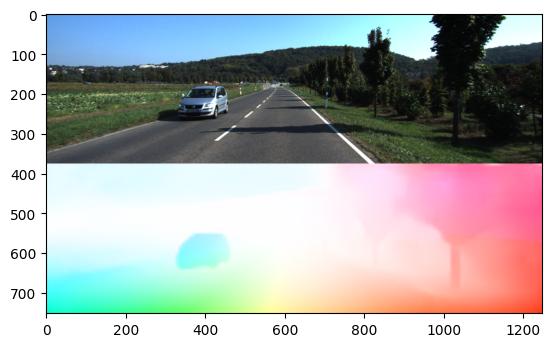

In [16]:

model = RAFT({})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

state_dict = torch.load("/content/drive/MyDrive/RAFT-master/Kitti_scratch_epoch_200.pth")
# state_dict_temp = {}
# for i in state_dict.keys():
#   state_dict_temp[i[7:]] = state_dict[i]
state_dict = rename_state_dict_keys(state_dict)

  # state_dict_temp[]
model.load_state_dict(state_dict, strict=True)


model.eval()

with torch.no_grad():
  flow_low, flow_up = model(image1, image2, test_mode=True)
  viz(image1, flow_up)

In [17]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve


video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
_ = urlretrieve(video_url, video_path)

In [18]:

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = torchvision.transforms.functional.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

def preprocess(img1_batch, img2_batch):
    img1_batch = torchvision.transforms.functional.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = torchvision.transforms.functional.resize(img2_batch, size=[520, 960], antialias=False)
    return img1_batch, img2_batch
    # return transforms(img1_batch, img2_batch)

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional
from torchvision.io import read_video

from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.utils import flow_to_image

from torchvision.io import write_jpeg





def create_gif_from_video(video_path, model, video_url = None):
  if video_url is not None:
    _ = urlretrieve(video_url, video_path)
  frames, _, _ = read_video(str(video_path), output_format="TCHW")

  img1_batch = torch.stack([frames[100], frames[150]])
  img2_batch = torch.stack([frames[101], frames[151]])

  # weights = Raft_Large_Weights.DEFAULT
  # transforms = weights.transforms()

  img1_batch = torchvision.transforms.functional.resize(img1_batch, size=[520, 960], antialias=False)
  img2_batch = torchvision.transforms.functional.resize(img2_batch, size=[520, 960], antialias=False)

  model = model.eval()
  list_of_flows = model(img1_batch.to(device), img2_batch.to(device))

  predicted_flows = list_of_flows[-1]

  flow_imgs = flow_to_image(predicted_flows)

  img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

  grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]

  for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1, img2 = preprocess(img1, img2)
    img1 = torch.unsqueeze(img1, dim=0)
    img2 = torch.unsqueeze(img2, dim=0)

    list_of_flows = model(img1.to(device), img2.to(device))
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    output_folder = "/content/drive/MyDrive/RAFT-master/runs/"  # Update this to the folder of your choice
    write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")


  # img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

  # plot(img1_batch)


In [20]:
model = RAFT({})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

state_dict = torch.load("/content/drive/MyDrive/RAFT-master/raft-small.pth")
state_dict_temp = {}
for i in state_dict.keys():
  state_dict_temp[i[7:]] = state_dict[i]
state_dict = rename_state_dict_keys(state_dict_temp)

  # state_dict_temp[]
model.load_state_dict(state_dict, strict=True)


model.eval()

# create_gif_from_video(video_path, model, video_url)

RAFT(
  (fnet): FeatureEncoder(
    (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BottleneckBlock(
        (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BottleneckBlock(
        (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), st

In [21]:
# !ffmpeg -f image2 -framerate 30 -i runspredicted_flow_%d.jpg -loop -1 flow.gif